
## The Curse of Dimensionality Applied to k-Nearest Neighbors

#### Daniel Hatchell
#### Department of Petroleum and Geosystems Engineering, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

* The curse of dimensionality describes the difficulties working with highly-dimensional datasets; beyond the challenge of visualizing and processing highly-dimensional data, the increased dimensions mean that data become more sparse and distances between data points become less meaningful.

* With k-nearest neighbors, we demonstrate the curse of dimensionality by comparing the quality of a prediction of a highly-dimensional dataset with a much smaller "feature-ranked" dataset.

* We demonstrate that, besides being difficult to work with and visualize, you can often get a worse prediction with a highly-dimensional dataset, even though the model incorporates more information.

* We recommend careful feature ranking to refine the dataset and improve predictions.

### Import Packages

In [1]:
import numpy as np                                       # Vector / matrix operations
import pandas as pd                                      # Dataframe handling
import matplotlib.pyplot as plt                          # Plot generation
import copy                                              # Used to copy data once loaded

from scipy import stats                                  # Used to calculate correlation during feature ranking
from scipy import linalg                                 # Used in calculation of partial/semipartial correlations

from sklearn.model_selection import train_test_split     # Used to split data into training and testing
from sklearn.neighbors import KNeighborsRegressor        # kNN algorithm
from sklearn.model_selection import cross_val_score      # Used for kNN cross validation
from sklearn.preprocessing import StandardScaler         # Used for variable scaling
from sklearn.impute import SimpleImputer                 # Used to impute missing values with mean
from sklearn.metrics import mean_squared_error           # Used to calculate MSE

### Functions

The following functions will be used in the workflow. 

partial_corr and semipartial_corr are borrowed from Professor Michael Pyrcz (@GeostatsGuy), at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb. plotkNN, plotkNN2, and kNNcrossval are adapted from 
https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb.


In [2]:
def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        print(i)
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        print(i)
    return P_corr

def plotkNN(y_train,predict_train,y_test,predict_test):
    # Plots results of kNN model
    plt.subplot(121)
    plt.scatter(y_train,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title('kNN with Training Data'); plt.xlabel('Scaled Response'); plt.ylabel('Estimated Scaled Response')
    plt.xlim(-2,3); plt.ylim(-2,3)
    plt.arrow(-2,-2,5,5,width=0.02,color='black',head_length=0.0,head_width=0.0)

    plt.subplot(122)
    plt.scatter(y_test,predict_test,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title('kNN with Testing Data'); plt.xlabel('Scaled Response'); plt.ylabel('Estimated Scaled Response')
    plt.xlim(-2,3); plt.ylim(-2,3)
    plt.arrow(-2,-2,5,5,width=0.02,color='black',head_length=0.0,head_width=0.0)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()
    
def plotkNN2(y_train,predict_train,y_test,predict_test,y_train2,predict_train2,y_test2,predict_test2):
    # Plots results of 2 kNN models
    plt.subplot(121)
    plt.scatter(y_train,predict_train,s=None, c='red',label = '345 features',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.scatter(y_train2,predict_train2,s=None, c='blue',label = '3 features',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title('kNN with Training Data'); plt.xlabel('Scaled Response'); plt.ylabel('Estimated Scaled Response')
    plt.xlim(-2,3); plt.ylim(-2,3)
    plt.arrow(-2,-2,5,5,width=0.02,color='black',head_length=0.0,head_width=0.0)

    plt.subplot(122)
    plt.scatter(y_test,predict_test,s=None, c='red',label = '345 features',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.scatter(y_test2,predict_test2,s=None, c='blue',label = '3 features',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.3, edgecolors="black")
    plt.title('kNN with Testing Data'); plt.xlabel('Scaled Response'); plt.ylabel('Estimated Scaled Response')
    plt.xlim(-2,3); plt.ylim(-2,3)
    plt.arrow(-2,-2,5,5,width=0.02,color='black',head_length=0.0,head_width=0.0)

    plt.legend()
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
    plt.show()
    
def kNNcrossval(df,sfeatures_use,response):
    # Cross validation of kNN model
    score1 = []                                                  # code modified from StackOverFlow by Dimosthenis
    score2 = []   
    score3 = []   
    score4 = []   
    k_mat = []
    for k in range(1,30):
        neigh_dist1 = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
        scores1 = cross_val_score(estimator=neigh_dist1, X= np.c_[df[sfeatures_use]],y=df[response], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
        score1.append(abs(scores1.mean()))
        neigh_dist2 = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 2)
        scores2 = cross_val_score(estimator=neigh_dist2, X= np.c_[df[sfeatures_use]],y=df[response], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
        score2.append(abs(scores2.mean()))
        neigh_dist3 = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
        scores3 = cross_val_score(estimator=neigh_dist3, X= np.c_[df[sfeatures_use]],y=df[response], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
        score3.append(abs(scores3.mean()))
        neigh_dist4 = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 2)
        scores4 = cross_val_score(estimator=neigh_dist4, X= np.c_[df[sfeatures_use]],y=df[response], cv=2, n_jobs=4,scoring = "neg_mean_squared_error") # Perform 7-fold cross validation
        score4.append(abs(scores4.mean()))
        k_mat.append(k)

    plt.figure(figsize=(8,6))
    plt.scatter(k_mat,score1,s=None, c="red", label = 'distance, p = 1', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5, edgecolors="black")
    plt.scatter(k_mat,score2,s=None, c="black", label = 'distance, p = 2', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5, edgecolors="black")
    plt.scatter(k_mat,score3,s=None, c="blue", label = 'uniform, p = 1', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5, edgecolors="black")
    plt.scatter(k_mat,score4,s=None, c="yellow", label = 'uniform, p = 2', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.5, edgecolors="black")
    plt.legend()
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
    plt.xlim(0,30); plt.ylim(0,1)
    plt.show()

### Load Data

The following workflow uses two open datasets, "weather_data" and "time_series". These datasets contain data related to the weather and electricity demand/generation of several European countries. The datasets are publically available [here](https://data.open-power-system-data.org/weather_data) and [here](https://data.open-power-system-data.org/time_series/). 

We will work with a large number of features, across several countries. Here are a few, as an example. The remaining features are described in the aforementioned websites. 

* **utc_timestamp** - Timestamp in UTC (hourly resolution)
* **temperature** - Population-weighted mean temperature in degrees Celcius
* **radiation_direct_horizontal** - Direct radiation in Watts / square meter
* **radiation_diffuse_horizontal** - Diffuse radiation in Watts / square meter
* **load_actual_entsoe_transparency** - Total national load in MW, from ENTSO-E
* **load_forecast_entsoe_transparency** - Day-ahead forecasted national load in MW, from ENTSO-E
* **price_day_ahead** - Day ahead spot price in euro
* **solar_generation_actual** - Actual solar generation in MW
* **wind_generation_actual** - Actual wind generation in MW
* **wind_offshore_generation_actual** - Actual offshore wind generation in MW
* **wind_onshore_generation_actual** - Actual onshore wind generation in MW

Note that the actual feature names are listed as 'XX_temperature', 'XX_wind_generation_actual', etc., with XX referring to the country's two-letter abbreviation (ie. 'NL_temperature'), or sometimes to a specific zone (ie. 'DE_LU' for the combined Germany-Luxembourg bidding zone).

We will load the data here (this may take a few minutes):

In [4]:
df_load_weather = pd.read_csv(r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv")
df_load_timeseries = pd.read_csv(r"https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv")

First, we will organize the datasets into a single dataframe, df. We will copy the datasets, drop any non-overlapping timestamps, and remove all hourly data except for 12 noon on each day. We will then concatenate the two dataframes into a single dataframe. From here, we will extract only the data from a single year (2019), remove columns with more than 10 NAN values, and impute with the mean (most of our columns are complete or have less than 10 NAN). The result is a numeric dataframe with 365 rows and 348 columns.

The line to reorder the dataframe columns was inspired by user BrenBarn at https://stackoverflow.com/questions/11067027/re-ordering-columns-in-pandas-dataframe-based-on-column-name, and the imputation code is borrowed from Professor Michael Pyrcz (@GeostatsGuy), at  https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Imputation.ipynb.

In [5]:
df_weather = copy.deepcopy(df_load_weather.loc[12::24,:]) # remove hourly data - keep only noon UTC each day
df_weather = df_weather.drop(df_weather.index[0:12784],axis = 0) # remove non-overlapping years (keep 2015-2019)
df_weather = df_weather.drop(['utc_timestamp'], axis=1) # remove timestamp index
df_weather = df_weather.reset_index(drop=True)

df_timeseries = copy.deepcopy(df_load_timeseries.loc[13::24,:]) # remove hourly data - keep only noon UTC each day
df_timeseries = df_timeseries.drop(df_timeseries.index[1826:],axis = 0) # remove non-overlapping years (keep 2015-2019)
df_timeseries = df_timeseries.drop(['utc_timestamp', 'cet_cest_timestamp'], axis=1) # remove timestamp index
df_timeseries = df_timeseries.reset_index(drop=True)

df = pd.concat([df_weather,df_timeseries], axis = 1)
df = df.reindex(sorted(df.columns), axis=1) # https://stackoverflow.com/questions/11067027/re-ordering-columns-in-pandas-dataframe-based-on-column-name
df = df.drop(df_timeseries.index[:1461],axis = 0) # remove data from 2015-2018; keep only 2019

df = df.dropna(axis=1, thresh=355)
mean_imputer = SimpleImputer(strategy='mean')
df.iloc[:,:] = mean_imputer.fit_transform(df)

### kNN  and the Curse of Dimensionality

Our goal is to predict wind generation (MW) in the Netherlands using a k-Nearest Neighbors model on timeseries data throughout 2019. We'll exclude the features NL_wind_generation_actual, NL_wind_offshore_generation_actual, and NL_wind_onshore_generation_actual, but initially retain everything else. NL_wind_generation_actual is our response feature.

We will follow this workflow:

1. Transform features with a standard scaler

2. Run kNN, and attempt to tune hyperparameters

3. Perform feature ranking

4. Run kNN again with selected features; tune hyperparameters

### 1. Feature Transformation

We'll use a standard scaler to transform our data (adapted from Professor Michael Pyrcz (@GeostatsGuy), at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [6]:
transform = StandardScaler(); 
sfeatures = []
j=0

for i in df.columns[0:-1]:
    df['s'+i] = transform.fit_transform(df.loc[:,i].values.reshape(-1, 1)) # standardize the data features to mean = 0, var = 1.0
    sfeatures.append('s'+i)
    j = j+1
    
sfeatures_use = sfeatures
response = 'sNL_wind_generation_actual'
sfeatures_use.remove(response)
sfeatures_use.remove('sNL_wind_offshore_generation_actual')
sfeatures_use.remove('sNL_wind_onshore_generation_actual') 

C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395342531.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['s'+i] = transform.fit_transform(df.loc[:,i].values.reshape(-1, 1)) # standardize the data features to mean = 0, var = 1.0
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395342531.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['s'+i] = transform.fit_transform(df.loc[:,i].values.reshape(-1, 1)) # standardize the data features to mean = 0, var = 1.0
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395

C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395342531.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['s'+i] = transform.fit_transform(df.loc[:,i].values.reshape(-1, 1)) # standardize the data features to mean = 0, var = 1.0
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395342531.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['s'+i] = transform.fit_transform(df.loc[:,i].values.reshape(-1, 1)) # standardize the data features to mean = 0, var = 1.0
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1395

### 2. Run naive kNN model to predict wind generation in the Netherlands

Here, we will try to use k-nearest neighbors. First, we'll split our testing and training data. Then, we will tune hyperparameters.

The crossval function is adapted from Professor Michael Pyrcz (@GeostatsGuy), at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb:

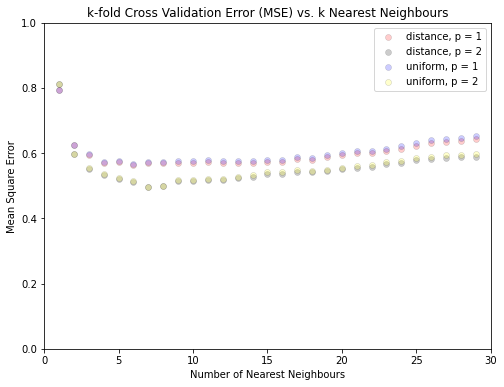

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[sfeatures_use], df[response], test_size=0.20, random_state=24601)

kNNcrossval(df,sfeatures_use,response)

It seems that distance weighted, p = 2, and k = 7 gives a good result. We can run kNN again with these hyperparameters.

The code executing kNN and plotkNN function are also adapted from Professor Michael Pyrcz (@GeostatsGuy), at  https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb.

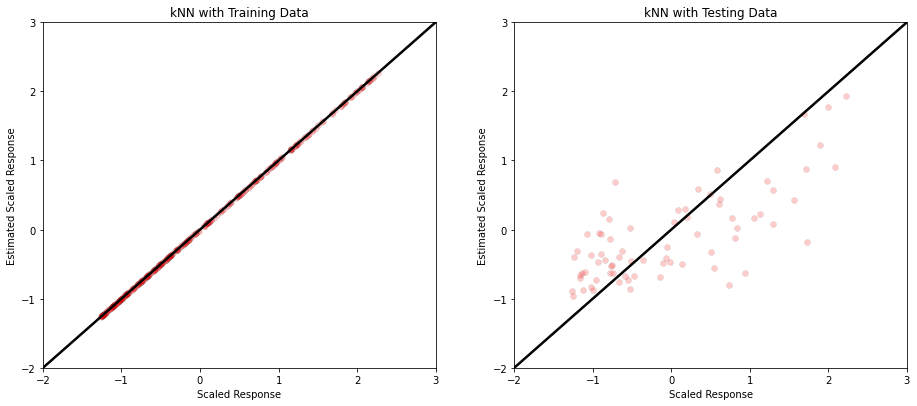

In [8]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=7, p = 2) # instantiate the prediction model
neigh_fit = neigh.fit(X_train,y_train)              # train the model with the training data

predict_train = neigh_fit.predict(X_train)
predict_test = neigh_fit.predict(X_test)

plotkNN(y_train,predict_train,y_test,predict_test)

This fit is ok, but we can do a little better by addressing our high dimensionality. We will do some feature ranking.

### 3. Feature Ranking

We will start by calculating the following parameters:

* **Rank Correlation**
* **Partial Correlation**
* **Semipartial Correlation**

This code is adapted from Professor Michael Pyrcz (@GeostatsGuy), at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb.

**Warning: this step takes a long time - up to an hour. The important output is printed in text below.** 

In [9]:
sfeatures2 = sfeatures_use

sfeatures2.append(response)

rank_correlation, rank_correlation_pval = stats.spearmanr(df[sfeatures2]) # calculate the range correlation coefficient
rank_correlation = rank_correlation[:,-1][:-1]
rank_correlation_pval = rank_correlation_pval[:,-1][:-1]
partial_correlation = partial_corr(df[sfeatures2]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,-1][:-1] # extract a single row and remove production with itself
semipartial_correlation = semipartial_corr(df[sfeatures2]) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,-1][:-1] # extract a single row and remove production with itself

sfeatures2.pop()

C:\Users\dchat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\dchat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1279365147.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_corr = np.zeros((p, p), dtype=np.float)
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1279365147.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1279365147.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  P_corr = np.zeros((p, p), dtype=np.float)
C:\Users\dchat\AppData\Local\Temp/ipykernel_16460/1279365147.py:39: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.ones(p, dtype=np.bool)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

'sNL_wind_generation_actual'

Once we've calculated the various correlation coefficients, we will print the ten most important features by each metric. The following code is based on a submission by user Akavall at https://stackoverflow.com/questions/10337533/a-fast-way-to-find-the-largest-n-elements-in-an-numpy-array:

In [10]:
print('rank correlation')
temp = np.argpartition(-np.abs(rank_correlation), 10)
for i in range(0,10):
    print(sfeatures2[temp[i]])

print('\npartial')
    
temp = np.argpartition(-np.abs(partial_correlation), 10)
for i in range(0,10):
    print(sfeatures2[temp[i]])

print('\nsemipartial')    
    
temp = np.argpartition(-np.abs(semipartial_correlation), 10)
for i in range(0,10):
    print(sfeatures2[temp[i]])

rank correlation
sDE_wind_profile
sDE_tennet_wind_generation_actual
sDE_wind_generation_actual
sDE_LU_wind_generation_actual
sDE_amprion_wind_onshore_generation_actual
sBE_wind_onshore_generation_actual
sDE_tennet_wind_onshore_generation_actual
sDE_tennet_wind_offshore_generation_actual
sDE_wind_onshore_profile
sDE_wind_onshore_generation_actual

partial
sCH_radiation_direct_horizontal
sFI_radiation_direct_horizontal
sES_temperature
sDE_tennet_wind_onshore_generation_actual
sDE_tennet_wind_offshore_generation_actual
sFI_radiation_diffuse_horizontal
sGB_radiation_diffuse_horizontal
sBE_wind_onshore_generation_actual
sCH_radiation_diffuse_horizontal
sSK_radiation_direct_horizontal

semipartial
sIT_SACO_DC_price_day_ahead
sIT_SICI_price_day_ahead
sPT_wind_onshore_generation_actual
sBG_solar_generation_actual
sBE_wind_onshore_generation_actual
sBG_wind_onshore_generation_actual
sCH_load_actual_entsoe_transparency
sCH_radiation_diffuse_horizontal
sGB_radiation_diffuse_horizontal
sFI_radiati

There are quite a few results here. If we take the top 10 most important features from the rank, partial, and semipartial correlations, we get the following table:

| Rank Correlation | Partial Correlation | Semipartial Correlation |
| --- | --- | --- |
| sDE_wind_profile | sCH_radiation_direct_horizontal | sIT_SACO_DC_price_day_ahead |
| sDE_tennet_wind_generation_actual | sFI_radiation_direct_horizontal | sIT_SICI_price_day_ahead |
| sDE_wind_generation_actual | sES_temperature | sPT_wind_onshore_generation_actual |
| sDE_LU_wind_generation_actual | sDE_tennet_wind_onshore_generation_actual | sBG_solar_generation_actual |
| sDE_amprion_wind_onshore_generation_actual | sDE_tennet_wind_offshore_generation_actual | sBE_wind_onshore_generation_actual |
| sBE_wind_onshore_generation_actual | sFI_radiation_diffuse_horizontal | sBG_wind_onshore_generation_actual |
| sDE_tennet_wind_onshore_generation_actual | sGB_radiation_diffuse_horizontal | sCH_load_actual_entsoe_transparency |
| sDE_tennet_wind_offshore_generation_actual | sBE_wind_onshore_generation_actual | sCH_radiation_diffuse_horizontal |
| sDE_wind_onshore_profile | sCH_radiation_diffuse_horizontal | sGB_radiation_diffuse_horizontal |
| sDE_wind_onshore_generation_actual | sSK_radiation_direct_horizontal | sFI_radiation_direct_horizontal |

With the goal of demonstrating the curse of dimensionality, we will be as selective as possible with our features. We'll only choose features listed twice or more above. From there, we'll manually discard features that do not explicitly deal with wind generation. Our curated list of features becomes:

| Rank Correlation | Description | Use or Discard? |
| --- | --- | --- |
| sBE_wind_onshore_generation_actual | Belgium actual onshore wind generation (MW) | Use |
| sDE_tennet_wind_offshore_generation_actual | Germany TenneT zone offshore wind generation (MW) | Use |
| sDE_tennet_wind_onshore_generation_actual | Germany TenneT zone onshore wind generation (MW) | Use |
| sCH_radiation_direct_horizontal | Switzerland direct radiation (W/m^2) | Discard |
| sFI_radiation_direct_horizontal | Finland direct radiation (W/m^2) | Discard |
| sCH_radiation_diffuse_horizontal | Switzerland diffuse radiation (W/m^2) | Discard |
| sGB_radiation_diffuse_horizontal | Great Britain diffuse radiation (W/m^2) | Discard |



### 4. kNN retry with fewer dimensions

We'll now run kNN again with only these 3 features. First, we'll do a new test-train split and tune hyperparameters with cross validation. This code and function is again adapted from Professor Michael Pyrcz (@GeostatsGuy), at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb.

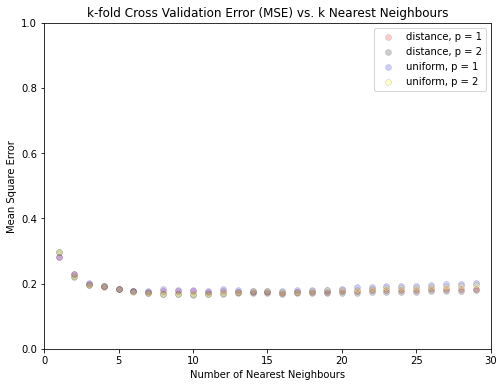

In [11]:
sfeatures2_use = ['sBE_wind_onshore_generation_actual','sDE_tennet_wind_offshore_generation_actual','sDE_tennet_wind_onshore_generation_actual']
X_train2, X_test2, y_train2, y_test2 = train_test_split(df[sfeatures2_use], df[response], test_size=0.20, random_state=24601)
kNNcrossval(df,sfeatures2_use,response)

The best hyperparameters appear to be distance weighted, p = 2, and k = 10. We can now run a tuned kNN model with 3 features, and compare it to the previous 345 feature model.

The original 345-feature model has an MSE of:
0.45938215355004053
The updated 3-feature model has an MSE of:
0.1448356560801893


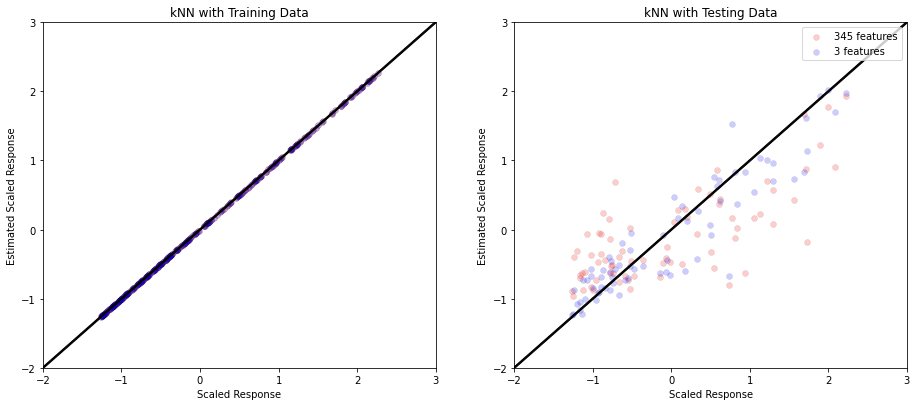

In [12]:
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=10, p = 2) # instantiate the prediction model
neigh_fit2 = neigh.fit(X_train2,y_train2)              # train the model with the training data

predict_train2 = neigh_fit2.predict(X_train2)
predict_test2 = neigh_fit2.predict(X_test2)

print('The original 345-feature model has an MSE of:')
print(np.sum((y_test-predict_test)**2)/len(y_test))

print('The updated 3-feature model has an MSE of:')
print(np.sum((y_test2-predict_test2)**2)/len(y_test2))

plotkNN2(y_train,predict_train,y_test,predict_test,y_train2,predict_train2,y_test2,predict_test2)

Our MSE is lower with 3 features than with 345 features - reducing the dimensionality has given us a better prediction.

### Results

We attempted to predict wind generation in the Netherlands for the year of 2019 given a broad dataset containing energy and weather information for several European countries. We first used a naive k-nearest neighbor model including all 345 scaled features to predict wind generation, which was only modestly successful. We then performed feature selection and chose 3 features. Running k-nearest neighbors again, we obtained a better prediction with 3 features than with 345, reducing our mean-squared error over the testing data from 0.407 to 0.145.

This workflow demonstrates the importance of understanding the available features, performing feature selection, and controlling for issues that arise at high dimensionality.


I hope this was helpful,

*Daniel Hatchell*

*dchatchell@utexas.edu*
___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
